# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0k/60.0k [00:11<00:00, 5.24kFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

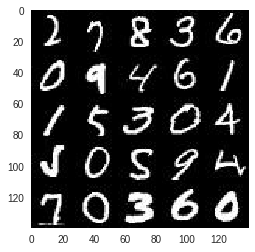

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.grid(False)
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

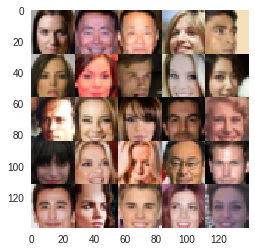

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.grid(False)
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.13.0-rc1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_ = tf.placeholder(tf.float32, 
                            shape=[None, image_width, image_height, image_channels],
                            name='input')
    input_z = tf.placeholder(tf.float32, shape=[None, z_dim], name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
      # Input is 28x28x?
      # 1st Convolutional layer
      conv1 = tf.layers.conv2d(images, filters=32, kernel_size=(5,5),
                           strides=(2,2), padding='same')
      conv1 = tf.nn.leaky_relu(conv1, alpha=alpha) # or tf.maximum(alpha*x, x)
      # 14x14x32 now
      
      # 2nd Convolutional layer
      conv2 = tf.layers.conv2d(conv1, filters=64, kernel_size=(5,5),
                               strides=(2,2), padding='same')
      conv2 = tf.layers.batch_normalization(conv2, training=True) # Batch normalizing
      conv2 = tf.nn.leaky_relu(conv2, alpha=alpha) # or tf.maximum(alpha*x, x)
      # 7x7x64 now
      
      # Flatten Layer
      flat = tf.reshape(conv2, (-1, 7*7*64))
      logits = tf.layers.dense(flat, 1)
      out = tf.nn.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()  File "/usr/local/lib/pyth

### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
      # z Layers
      x = tf.layers.dense(z, 7*7*64)
      x = tf.reshape(x, (-1, 7, 7, 64))
      x = tf.layers.batch_normalization(x, training=is_train)
      x = tf.nn.leaky_relu(x, alpha=alpha)
      # 7x7x64 now
      
      # 1st Transpose Convolutional
      conv1_t = tf.layers.conv2d_transpose(x, filters=32, kernel_size=(5,5), 
                                           strides=(2,2), padding='same')
      conv1_t = tf.layers.batch_normalization(conv1_t, training=is_train)
      conv1_t = tf.nn.leaky_relu(conv1_t, alpha=alpha)
      # 14x14x32 now
      
      # 2nd Transpose Convolutional
      logits = tf.identity(
          tf.layers.conv2d_transpose(conv1_t, filters=out_channel_dim, 
                                     kernel_size=(5,5), strides=(2,2), 
                                     padding='same'), name='conv2_t')
      out = tf.nn.tanh(logits)
      # 28x28x? now
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]    
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
      d_opt = tf.train.AdamOptimizer(
          learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
      g_opt = tf.train.AdamOptimizer(
          learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.grid(False)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
    return samples

### Show Losses
Use this function to show the losses during training.

In [0]:
def show_losses(losses, x_label):
  """
  Show generator and discriminator losses
  :param losses: A list of tuple of (discriminator losses, generator losses)
  """
  pyplot.figure(figsize=(10, 10))
  fig, ax = pyplot.subplots()
  losses_ = np.array(losses)
  pyplot.plot(losses_.T[0], label='Discriminator', alpha=0.5)
  pyplot.plot(losses_.T[1], label='Generator', alpha=0.5)
  pyplot.title("Training Losses")
  pyplot.xlabel(x_label)
  pyplot.ylabel("Losses")
  pyplot.legend()
  pyplot.show()

### Generate Images
Use this function to generate new images after training.

In [0]:
import dcgan

def generate_image(graph, n_images, image_mode):
  """
  Generatoe new images.
  :param graph: TensorFlow graph
  :param n_images: Number of Images to display
  :param image_mode: The mode to use for images ("RGB" or "L")
  """
  cmap = None if image_mode == 'RGB' else 'gray'
  channel = 3 if image_mode == 'RGB' else 1 
  example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
  with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess, 'checkpoints/generator_{}.ckpt'.format(image_mode))
    samples = sess.run(
        model.generator(model.input_z, out_channel_dim=channel, 
                        is_train=False), feed_dict={model.input_z: example_z})
    sess.close()
  
  images_grid = helper.images_square_grid(samples, image_mode)
  pyplot.grid(False)
  pyplot.imshow(images_grid, cmap=cmap)
  pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [0]:
!mkdir checkpoints pkl

In [0]:
import pickle as pkl

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, 
                                           image_height, 
                                           image_channels,
                                           z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)    
    
    print_every, show_every = 10, 100
    samples, losses_per_epoch, losses_per_batch = [], [], []
    steps = 0
    d_cost, g_cost = 0, 0
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Convert images to a range of -1 to 1
                batch_images *= 2.0 
                
                # Sample random noise for generator (G)
                batch_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])
                
                # Run optimizers
                feed = {
                        input_real: batch_images, 
                        input_z: batch_z,
                        lr: learning_rate
                       }
                _ = sess.run(d_train_opt, feed_dict=feed)
                _ = sess.run(g_train_opt, feed_dict=feed)
                 
                if steps % print_every == 0:
                  # At the end of each epoch, get the losses and print them out
                  d_cost = d_loss.eval({input_real: batch_images, input_z: batch_z})
                  g_cost = g_loss.eval({input_z: batch_z})
                  print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                        "Discriminator loss: {:.4f}...".format(d_cost),
                        "Generator loss: {:.4f}".format(g_cost))
                  
                  # Save losses per batch
                  losses_per_batch.append((d_cost, g_cost))
                
                if steps % show_every == 0:
                  gen_samples = show_generator_output(sess, 
                                                      72, 
                                                      input_z, 
                                                      image_channels, 
                                                      data_image_mode)
                  samples.append(gen_samples)
                  
            # Save losses per epoch
            losses_per_epoch.append((d_cost, g_cost))
        # Save Model
        saver.save(sess, "checkpoints/generator_{}.ckpt".format(data_image_mode))
    
    with open('pkl/samples_{}.pkl'.format(data_image_mode), 'wb') as f:
      pkl.dump(samples, f)
    with open('pkl/losses_per_epoch_{}.pkl'.format(data_image_mode), 'wb') as f:
      pkl.dump(losses_per_epoch, f)
    with open('pkl/losses_per_batch_{}.pkl'.format(data_image_mode), 'wb') as f:
      pkl.dump(losses_per_batch, f)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator loss: 0.7253... Generator loss: 1.4376
Epoch 1/2... Discriminator loss: 1.5058... Generator loss: 0.5763
Epoch 1/2... Discriminator loss: 1.1488... Generator loss: 1.0827
Epoch 1/2... Discriminator loss: 0.8848... Generator loss: 1.4679
Epoch 1/2... Discriminator loss: 1.2780... Generator loss: 0.9639
Epoch 1/2... Discriminator loss: 1.2455... Generator loss: 0.7323
Epoch 1/2... Discriminator loss: 1.2224... Generator loss: 0.7840
Epoch 1/2... Discriminator loss: 1.3770... Generator loss: 1.8943
Epoch 1/2... Discriminator loss: 1.4689... Generator loss: 0.4534
Epoch 1/2... Discriminator loss: 1.0855... Generator loss: 0.9964


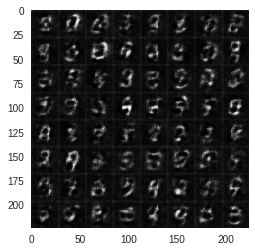

Epoch 1/2... Discriminator loss: 1.0961... Generator loss: 1.0736
Epoch 1/2... Discriminator loss: 1.3404... Generator loss: 1.8564
Epoch 1/2... Discriminator loss: 1.1368... Generator loss: 0.8237
Epoch 1/2... Discriminator loss: 1.1975... Generator loss: 0.7137
Epoch 1/2... Discriminator loss: 1.1056... Generator loss: 0.8764
Epoch 1/2... Discriminator loss: 1.0640... Generator loss: 1.1881
Epoch 1/2... Discriminator loss: 1.0679... Generator loss: 0.9496
Epoch 1/2... Discriminator loss: 1.1000... Generator loss: 0.8765
Epoch 1/2... Discriminator loss: 1.0827... Generator loss: 0.8982
Epoch 1/2... Discriminator loss: 1.1842... Generator loss: 0.6404


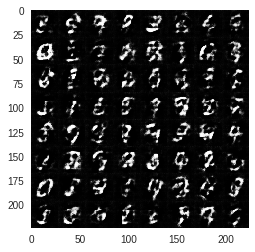

Epoch 1/2... Discriminator loss: 1.0863... Generator loss: 0.9967
Epoch 1/2... Discriminator loss: 0.9692... Generator loss: 1.0850
Epoch 1/2... Discriminator loss: 1.0499... Generator loss: 0.9547
Epoch 1/2... Discriminator loss: 1.0966... Generator loss: 0.8605
Epoch 1/2... Discriminator loss: 1.1100... Generator loss: 0.8105
Epoch 1/2... Discriminator loss: 1.0591... Generator loss: 1.4823
Epoch 1/2... Discriminator loss: 0.9778... Generator loss: 1.2976
Epoch 1/2... Discriminator loss: 1.1381... Generator loss: 0.7337
Epoch 1/2... Discriminator loss: 1.0100... Generator loss: 1.0649
Epoch 1/2... Discriminator loss: 1.1010... Generator loss: 0.9109


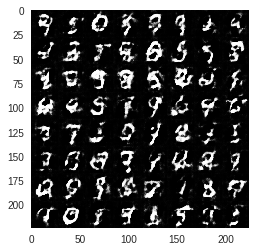

Epoch 1/2... Discriminator loss: 0.9728... Generator loss: 1.1134
Epoch 1/2... Discriminator loss: 1.0849... Generator loss: 0.7879
Epoch 1/2... Discriminator loss: 1.1386... Generator loss: 0.8001
Epoch 1/2... Discriminator loss: 1.2395... Generator loss: 0.6129
Epoch 1/2... Discriminator loss: 1.0918... Generator loss: 1.2488
Epoch 1/2... Discriminator loss: 1.0441... Generator loss: 1.4015
Epoch 1/2... Discriminator loss: 0.9873... Generator loss: 1.0848
Epoch 1/2... Discriminator loss: 1.0386... Generator loss: 0.9446
Epoch 1/2... Discriminator loss: 1.1710... Generator loss: 1.5696
Epoch 1/2... Discriminator loss: 1.0991... Generator loss: 0.9428


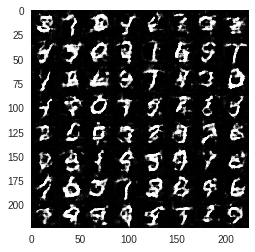

Epoch 1/2... Discriminator loss: 1.0702... Generator loss: 0.9182
Epoch 1/2... Discriminator loss: 1.0613... Generator loss: 1.0999
Epoch 1/2... Discriminator loss: 1.0998... Generator loss: 1.4363
Epoch 1/2... Discriminator loss: 1.0507... Generator loss: 1.0658
Epoch 1/2... Discriminator loss: 1.2581... Generator loss: 0.5845
Epoch 1/2... Discriminator loss: 1.2580... Generator loss: 1.6071
Epoch 2/2... Discriminator loss: 1.1289... Generator loss: 1.3278
Epoch 2/2... Discriminator loss: 1.0790... Generator loss: 0.8463
Epoch 2/2... Discriminator loss: 1.2025... Generator loss: 0.6311
Epoch 2/2... Discriminator loss: 1.2633... Generator loss: 0.5977


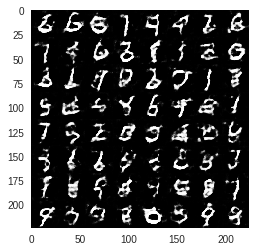

Epoch 2/2... Discriminator loss: 1.0335... Generator loss: 1.1214
Epoch 2/2... Discriminator loss: 1.0758... Generator loss: 1.4521
Epoch 2/2... Discriminator loss: 1.1392... Generator loss: 1.5455
Epoch 2/2... Discriminator loss: 1.2073... Generator loss: 0.6565
Epoch 2/2... Discriminator loss: 1.2039... Generator loss: 1.7618
Epoch 2/2... Discriminator loss: 1.0549... Generator loss: 1.2287
Epoch 2/2... Discriminator loss: 1.2464... Generator loss: 1.7221
Epoch 2/2... Discriminator loss: 1.1104... Generator loss: 1.0627
Epoch 2/2... Discriminator loss: 1.2604... Generator loss: 0.8763
Epoch 2/2... Discriminator loss: 1.3275... Generator loss: 0.5812


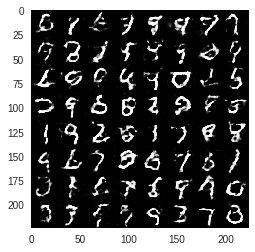

Epoch 2/2... Discriminator loss: 1.2153... Generator loss: 1.5484
Epoch 2/2... Discriminator loss: 1.1614... Generator loss: 1.3261
Epoch 2/2... Discriminator loss: 1.1386... Generator loss: 1.2306
Epoch 2/2... Discriminator loss: 1.0791... Generator loss: 1.0779
Epoch 2/2... Discriminator loss: 1.1896... Generator loss: 1.1824
Epoch 2/2... Discriminator loss: 1.5162... Generator loss: 0.4310
Epoch 2/2... Discriminator loss: 1.1180... Generator loss: 1.0436
Epoch 2/2... Discriminator loss: 1.1535... Generator loss: 1.2575
Epoch 2/2... Discriminator loss: 1.1403... Generator loss: 1.0951
Epoch 2/2... Discriminator loss: 1.2002... Generator loss: 0.7777


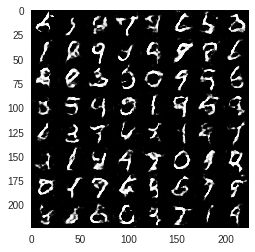

Epoch 2/2... Discriminator loss: 1.1411... Generator loss: 0.8839
Epoch 2/2... Discriminator loss: 1.0014... Generator loss: 1.0902
Epoch 2/2... Discriminator loss: 1.1281... Generator loss: 0.8419
Epoch 2/2... Discriminator loss: 1.1670... Generator loss: 0.8728
Epoch 2/2... Discriminator loss: 1.1471... Generator loss: 1.3240
Epoch 2/2... Discriminator loss: 1.2237... Generator loss: 1.4812
Epoch 2/2... Discriminator loss: 1.1235... Generator loss: 0.9721
Epoch 2/2... Discriminator loss: 1.0944... Generator loss: 0.9664
Epoch 2/2... Discriminator loss: 1.2059... Generator loss: 0.7147
Epoch 2/2... Discriminator loss: 1.1835... Generator loss: 1.4516


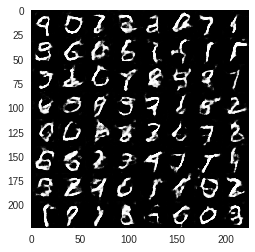

Epoch 2/2... Discriminator loss: 1.0889... Generator loss: 1.0536
Epoch 2/2... Discriminator loss: 1.3066... Generator loss: 0.5827
Epoch 2/2... Discriminator loss: 1.1651... Generator loss: 0.8637
Epoch 2/2... Discriminator loss: 1.1511... Generator loss: 0.9768
Epoch 2/2... Discriminator loss: 1.1314... Generator loss: 1.2709
Epoch 2/2... Discriminator loss: 1.3365... Generator loss: 1.6736
Epoch 2/2... Discriminator loss: 1.2459... Generator loss: 0.6608
Epoch 2/2... Discriminator loss: 1.1328... Generator loss: 0.9638
Epoch 2/2... Discriminator loss: 1.2712... Generator loss: 0.6019
Epoch 2/2... Discriminator loss: 1.1451... Generator loss: 1.0092


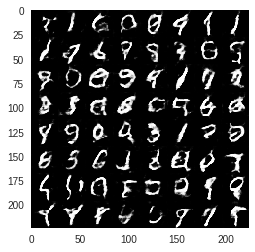

Epoch 2/2... Discriminator loss: 1.1109... Generator loss: 1.0945
Epoch 2/2... Discriminator loss: 1.1795... Generator loss: 0.7196
Epoch 2/2... Discriminator loss: 1.0793... Generator loss: 1.3290


In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

In [16]:
tf.train.latest_checkpoint('checkpoints')

'checkpoints/generator_L.ckpt'

<Figure size 720x720 with 0 Axes>

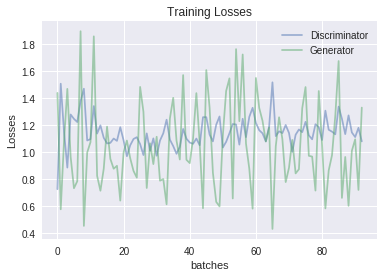

In [17]:
with open('pkl/losses_per_batch_{}.pkl'.format(mnist_dataset.image_mode), 'rb') as f:
  losses = pkl.load(f)
  
show_losses(losses, 'batches')

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoints/generator_L.ckpt


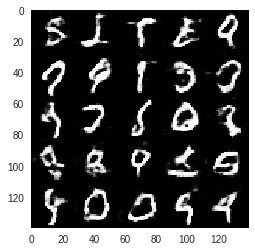

In [18]:
model = dcgan.DCGAN(mnist_dataset.shape, z_dim)
generate_image(model.graph, 32, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator loss: 1.0827... Generator loss: 0.8517
Epoch 1/1... Discriminator loss: 1.1568... Generator loss: 0.7715
Epoch 1/1... Discriminator loss: 1.1031... Generator loss: 0.9947
Epoch 1/1... Discriminator loss: 0.8838... Generator loss: 1.3142
Epoch 1/1... Discriminator loss: 0.7630... Generator loss: 1.6995
Epoch 1/1... Discriminator loss: 0.6591... Generator loss: 1.8403
Epoch 1/1... Discriminator loss: 0.6894... Generator loss: 1.8168
Epoch 1/1... Discriminator loss: 0.6719... Generator loss: 1.8210
Epoch 1/1... Discriminator loss: 0.6721... Generator loss: 1.8816
Epoch 1/1... Discriminator loss: 0.6814... Generator loss: 1.6952


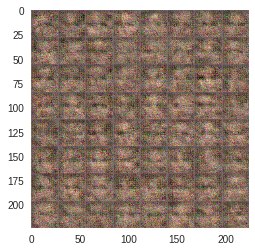

Epoch 1/1... Discriminator loss: 0.6815... Generator loss: 1.7023
Epoch 1/1... Discriminator loss: 0.7459... Generator loss: 1.5439
Epoch 1/1... Discriminator loss: 0.8518... Generator loss: 1.3948
Epoch 1/1... Discriminator loss: 0.7799... Generator loss: 1.5618
Epoch 1/1... Discriminator loss: 0.9278... Generator loss: 1.5188
Epoch 1/1... Discriminator loss: 0.8340... Generator loss: 1.5649
Epoch 1/1... Discriminator loss: 0.8493... Generator loss: 1.4666
Epoch 1/1... Discriminator loss: 0.9439... Generator loss: 1.1887
Epoch 1/1... Discriminator loss: 0.7967... Generator loss: 1.6657
Epoch 1/1... Discriminator loss: 0.7728... Generator loss: 1.9072


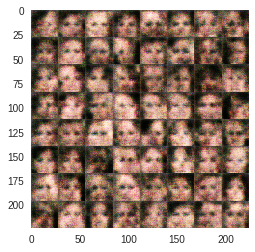

Epoch 1/1... Discriminator loss: 0.7805... Generator loss: 1.5119
Epoch 1/1... Discriminator loss: 0.8195... Generator loss: 1.8446
Epoch 1/1... Discriminator loss: 0.8489... Generator loss: 1.6847
Epoch 1/1... Discriminator loss: 0.9109... Generator loss: 1.4086
Epoch 1/1... Discriminator loss: 0.8758... Generator loss: 1.3012
Epoch 1/1... Discriminator loss: 0.8609... Generator loss: 1.3289
Epoch 1/1... Discriminator loss: 0.8829... Generator loss: 1.2594
Epoch 1/1... Discriminator loss: 0.9771... Generator loss: 1.0123
Epoch 1/1... Discriminator loss: 0.9374... Generator loss: 1.4079
Epoch 1/1... Discriminator loss: 0.8917... Generator loss: 1.1901


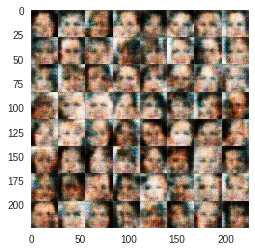

Epoch 1/1... Discriminator loss: 0.9750... Generator loss: 1.2978
Epoch 1/1... Discriminator loss: 1.1750... Generator loss: 0.7899
Epoch 1/1... Discriminator loss: 1.2524... Generator loss: 0.7304
Epoch 1/1... Discriminator loss: 1.1513... Generator loss: 1.0298
Epoch 1/1... Discriminator loss: 1.0875... Generator loss: 1.2330
Epoch 1/1... Discriminator loss: 1.1930... Generator loss: 1.0022
Epoch 1/1... Discriminator loss: 1.0666... Generator loss: 1.0946
Epoch 1/1... Discriminator loss: 1.1781... Generator loss: 1.1919
Epoch 1/1... Discriminator loss: 1.1554... Generator loss: 1.2219
Epoch 1/1... Discriminator loss: 1.1591... Generator loss: 1.2379


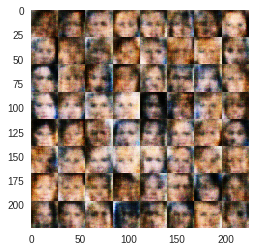

Epoch 1/1... Discriminator loss: 1.1205... Generator loss: 0.9980
Epoch 1/1... Discriminator loss: 1.1895... Generator loss: 0.9613
Epoch 1/1... Discriminator loss: 1.0853... Generator loss: 1.2395
Epoch 1/1... Discriminator loss: 1.1796... Generator loss: 0.8927
Epoch 1/1... Discriminator loss: 1.0544... Generator loss: 1.2046
Epoch 1/1... Discriminator loss: 1.1235... Generator loss: 1.0673
Epoch 1/1... Discriminator loss: 1.2060... Generator loss: 1.1647
Epoch 1/1... Discriminator loss: 1.0737... Generator loss: 1.0539
Epoch 1/1... Discriminator loss: 1.1525... Generator loss: 1.0625
Epoch 1/1... Discriminator loss: 1.1347... Generator loss: 0.9639


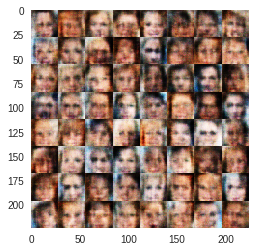

Epoch 1/1... Discriminator loss: 1.0696... Generator loss: 1.1429
Epoch 1/1... Discriminator loss: 1.0848... Generator loss: 1.1517
Epoch 1/1... Discriminator loss: 1.0580... Generator loss: 1.2685
Epoch 1/1... Discriminator loss: 1.1028... Generator loss: 0.9323
Epoch 1/1... Discriminator loss: 1.1431... Generator loss: 0.8673
Epoch 1/1... Discriminator loss: 1.1658... Generator loss: 0.8947
Epoch 1/1... Discriminator loss: 1.1684... Generator loss: 0.9949
Epoch 1/1... Discriminator loss: 1.0347... Generator loss: 1.0679
Epoch 1/1... Discriminator loss: 1.2743... Generator loss: 0.9376
Epoch 1/1... Discriminator loss: 1.0151... Generator loss: 1.1425


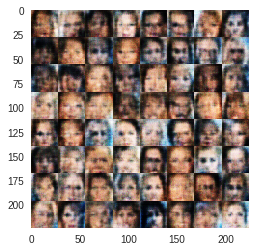

Epoch 1/1... Discriminator loss: 1.0903... Generator loss: 1.2483
Epoch 1/1... Discriminator loss: 1.1087... Generator loss: 1.0238
Epoch 1/1... Discriminator loss: 1.0002... Generator loss: 1.1452
Epoch 1/1... Discriminator loss: 1.1153... Generator loss: 1.1740
Epoch 1/1... Discriminator loss: 0.9554... Generator loss: 1.1582
Epoch 1/1... Discriminator loss: 1.1456... Generator loss: 0.9730
Epoch 1/1... Discriminator loss: 1.1788... Generator loss: 0.9902
Epoch 1/1... Discriminator loss: 1.2256... Generator loss: 1.3030
Epoch 1/1... Discriminator loss: 1.0802... Generator loss: 1.2664
Epoch 1/1... Discriminator loss: 0.9670... Generator loss: 1.0981


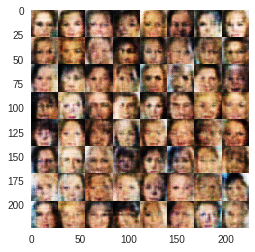

Epoch 1/1... Discriminator loss: 1.0159... Generator loss: 1.2107
Epoch 1/1... Discriminator loss: 1.1881... Generator loss: 0.7579
Epoch 1/1... Discriminator loss: 1.0866... Generator loss: 1.0185
Epoch 1/1... Discriminator loss: 1.0427... Generator loss: 1.0209
Epoch 1/1... Discriminator loss: 1.4900... Generator loss: 1.9121
Epoch 1/1... Discriminator loss: 1.1802... Generator loss: 0.9986
Epoch 1/1... Discriminator loss: 1.0793... Generator loss: 1.1366
Epoch 1/1... Discriminator loss: 1.2143... Generator loss: 0.8661
Epoch 1/1... Discriminator loss: 1.1378... Generator loss: 0.9695
Epoch 1/1... Discriminator loss: 1.1280... Generator loss: 0.9763


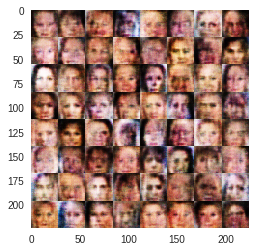

Epoch 1/1... Discriminator loss: 1.1090... Generator loss: 1.0158
Epoch 1/1... Discriminator loss: 1.0436... Generator loss: 1.1848
Epoch 1/1... Discriminator loss: 1.1718... Generator loss: 1.0133
Epoch 1/1... Discriminator loss: 1.0739... Generator loss: 1.0091
Epoch 1/1... Discriminator loss: 1.1787... Generator loss: 1.1001
Epoch 1/1... Discriminator loss: 1.1737... Generator loss: 0.8367
Epoch 1/1... Discriminator loss: 1.0813... Generator loss: 0.9552
Epoch 1/1... Discriminator loss: 1.1653... Generator loss: 0.9769
Epoch 1/1... Discriminator loss: 1.2865... Generator loss: 0.8401
Epoch 1/1... Discriminator loss: 1.3477... Generator loss: 0.8270


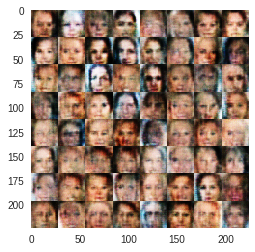

Epoch 1/1... Discriminator loss: 1.1831... Generator loss: 0.9309
Epoch 1/1... Discriminator loss: 1.2287... Generator loss: 0.9205
Epoch 1/1... Discriminator loss: 1.3610... Generator loss: 0.9916
Epoch 1/1... Discriminator loss: 1.2638... Generator loss: 1.1674
Epoch 1/1... Discriminator loss: 1.4000... Generator loss: 0.7621
Epoch 1/1... Discriminator loss: 1.3094... Generator loss: 0.6226
Epoch 1/1... Discriminator loss: 1.4348... Generator loss: 0.6412
Epoch 1/1... Discriminator loss: 1.1009... Generator loss: 1.0032
Epoch 1/1... Discriminator loss: 1.2649... Generator loss: 0.9842
Epoch 1/1... Discriminator loss: 1.2001... Generator loss: 1.0370


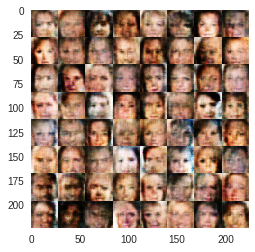

Epoch 1/1... Discriminator loss: 1.2763... Generator loss: 0.9357
Epoch 1/1... Discriminator loss: 1.2759... Generator loss: 0.9805
Epoch 1/1... Discriminator loss: 1.2773... Generator loss: 0.8317
Epoch 1/1... Discriminator loss: 1.3736... Generator loss: 0.9025
Epoch 1/1... Discriminator loss: 1.2389... Generator loss: 0.8444
Epoch 1/1... Discriminator loss: 1.3666... Generator loss: 0.8052
Epoch 1/1... Discriminator loss: 1.2675... Generator loss: 0.9398
Epoch 1/1... Discriminator loss: 1.2874... Generator loss: 0.8784
Epoch 1/1... Discriminator loss: 1.2538... Generator loss: 0.9147
Epoch 1/1... Discriminator loss: 1.2960... Generator loss: 0.9337


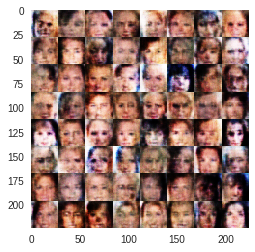

Epoch 1/1... Discriminator loss: 1.3520... Generator loss: 0.7862
Epoch 1/1... Discriminator loss: 1.4152... Generator loss: 0.6512
Epoch 1/1... Discriminator loss: 1.2968... Generator loss: 0.9875
Epoch 1/1... Discriminator loss: 1.2876... Generator loss: 0.9686
Epoch 1/1... Discriminator loss: 1.1641... Generator loss: 1.0578
Epoch 1/1... Discriminator loss: 1.2852... Generator loss: 0.9629
Epoch 1/1... Discriminator loss: 1.3536... Generator loss: 0.8568
Epoch 1/1... Discriminator loss: 1.3215... Generator loss: 0.8870
Epoch 1/1... Discriminator loss: 1.2632... Generator loss: 0.8069
Epoch 1/1... Discriminator loss: 1.3248... Generator loss: 0.8057


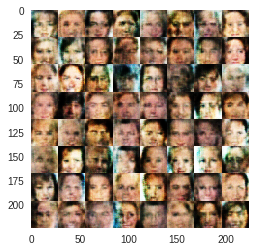

Epoch 1/1... Discriminator loss: 1.3605... Generator loss: 0.8684
Epoch 1/1... Discriminator loss: 1.2101... Generator loss: 0.8829
Epoch 1/1... Discriminator loss: 1.3714... Generator loss: 0.7177
Epoch 1/1... Discriminator loss: 1.3368... Generator loss: 0.8815
Epoch 1/1... Discriminator loss: 1.3814... Generator loss: 1.2697
Epoch 1/1... Discriminator loss: 1.3635... Generator loss: 0.8855
Epoch 1/1... Discriminator loss: 1.4287... Generator loss: 0.8697
Epoch 1/1... Discriminator loss: 1.3842... Generator loss: 0.8143
Epoch 1/1... Discriminator loss: 1.3129... Generator loss: 0.8618
Epoch 1/1... Discriminator loss: 1.2939... Generator loss: 0.9006


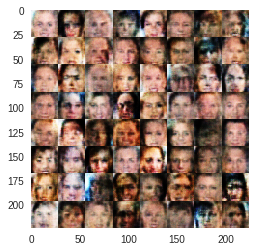

Epoch 1/1... Discriminator loss: 1.4032... Generator loss: 0.7908
Epoch 1/1... Discriminator loss: 1.4283... Generator loss: 0.7631
Epoch 1/1... Discriminator loss: 1.2707... Generator loss: 1.1078
Epoch 1/1... Discriminator loss: 1.3461... Generator loss: 0.8926
Epoch 1/1... Discriminator loss: 1.2937... Generator loss: 1.0034
Epoch 1/1... Discriminator loss: 1.3155... Generator loss: 0.8352
Epoch 1/1... Discriminator loss: 1.3301... Generator loss: 1.0419
Epoch 1/1... Discriminator loss: 1.3350... Generator loss: 0.7751
Epoch 1/1... Discriminator loss: 1.3504... Generator loss: 0.8078
Epoch 1/1... Discriminator loss: 1.3547... Generator loss: 0.8510


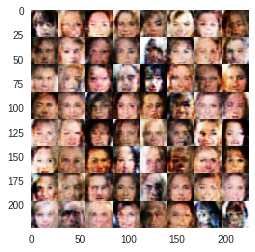

Epoch 1/1... Discriminator loss: 1.3789... Generator loss: 0.8753
Epoch 1/1... Discriminator loss: 1.2996... Generator loss: 0.8787
Epoch 1/1... Discriminator loss: 1.3014... Generator loss: 0.7658
Epoch 1/1... Discriminator loss: 1.3710... Generator loss: 0.7576
Epoch 1/1... Discriminator loss: 1.2519... Generator loss: 1.1580
Epoch 1/1... Discriminator loss: 1.3265... Generator loss: 0.9131
Epoch 1/1... Discriminator loss: 1.3218... Generator loss: 0.8202
Epoch 1/1... Discriminator loss: 1.4143... Generator loss: 0.8508
Epoch 1/1... Discriminator loss: 1.3532... Generator loss: 0.9577
Epoch 1/1... Discriminator loss: 1.2994... Generator loss: 0.9067


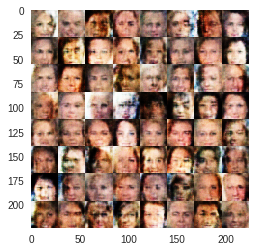

Epoch 1/1... Discriminator loss: 1.2474... Generator loss: 0.9006
Epoch 1/1... Discriminator loss: 1.3638... Generator loss: 0.8155
Epoch 1/1... Discriminator loss: 1.4114... Generator loss: 0.7762
Epoch 1/1... Discriminator loss: 1.3837... Generator loss: 0.6591
Epoch 1/1... Discriminator loss: 1.3916... Generator loss: 0.7520
Epoch 1/1... Discriminator loss: 1.3126... Generator loss: 0.8606
Epoch 1/1... Discriminator loss: 1.2491... Generator loss: 0.9992
Epoch 1/1... Discriminator loss: 1.2676... Generator loss: 0.8767


In [19]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

In [20]:
tf.train.latest_checkpoint('checkpoints')

'checkpoints/generator_RGB.ckpt'

<Figure size 720x720 with 0 Axes>

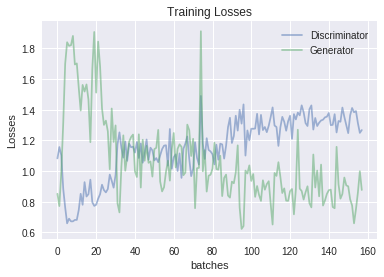

In [21]:
with open('pkl/losses_per_batch_{}.pkl'.format(celeba_dataset.image_mode), 'rb') as f:
  losses = pkl.load(f)
  
show_losses(losses, 'batches')

INFO:tensorflow:Restoring parameters from checkpoints/generator_RGB.ckpt


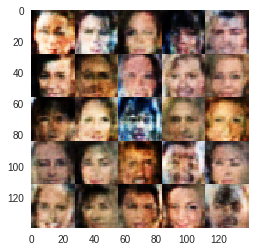

In [22]:
model = dcgan.DCGAN(celeba_dataset.shape, z_dim)
generate_image(model.graph, 32, celeba_dataset.image_mode)

## Visual Analysis
We use a method for visual analysis fo a neural network is also know as *feature maximization* or *activation maximization*, [paper 1](https://arxiv.org/pdf/1506.06579.pdf) and [paper 2](https://arxiv.org/pdf/1602.03616.pdf). The idea is to generate an image that maximizes individual features inside the neural network. The image is initialized with a little random noise and then gradually changed using the gradient of the given feature with regard to the input image.

In [0]:
from visual_analyze import Filter_Analyses

def visual_filters(dataset, z_dim, image_mode, function, conv_id=0, num_iterations=10):
  model = dcgan.DCGAN(dataset.shape, z_dim)
  with tf.Session(graph=model.graph) as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess, 'checkpoints/generator_{}.ckpt'.format(image_mode))
    
    filters = Filter_Analyses(model, sess)
    if function == 'optimize_images':
      return filters.optimize_images(conv_id=conv_id, num_iterations=num_iterations)
    elif function == 'optimize_image':
      return filters.optimize_image(conv_id=conv_id, num_iterations=num_iterations)

In [0]:
filters = Filter_Analyses()

### MNIST Feature Maximization 

### Discriminator First Convolutional Layer
These are the input images that maximize the features in the first convolutional layer, so these are the images that it likes to see.

INFO:tensorflow:Restoring parameters from checkpoints/generator_L.ckpt
Layer: discriminator/conv2d/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


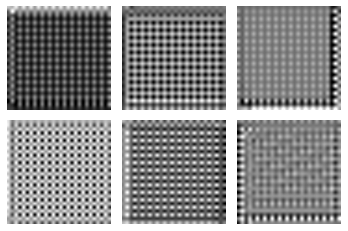

In [31]:
images = visual_filters(mnist_dataset, z_dim, mnist_dataset.image_mode, 
                        function='optimize_images', conv_id=0, num_iterations=50)
filters.plot_images10(images)

### Discriminator Second Convolutional Layer
This shows the images that maximize the features or neurons in the second convolutional layer, so these are the input images it likes to see. Note how these are more complex lines and patterns compared to the first convolutional layer.

INFO:tensorflow:Restoring parameters from checkpoints/generator_L.ckpt
Layer: discriminator/conv2d_1/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


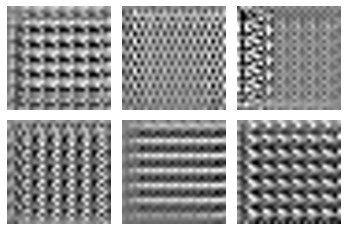

In [32]:
images = visual_filters(mnist_dataset, z_dim, mnist_dataset.image_mode,
                        function='optimize_images', conv_id=1, num_iterations=50)
filters.plot_images10(images)

### CelebA Feature Maximization 

### Discriminator First Convolutional Layer
These are the input images that maximize the features in the first convolutional layer, so these are the images that it likes to see.

INFO:tensorflow:Restoring parameters from checkpoints/generator_RGB.ckpt
Layer: discriminator/conv2d/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


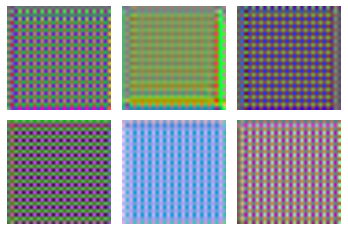

In [33]:
images = visual_filters(celeba_dataset, z_dim, celeba_dataset.image_mode, 
                        function='optimize_images', conv_id=0, num_iterations=50)
filters.plot_images(images)

### Discriminator Second Convolutional Layer
This shows the images that maximize the features or neurons in the second convolutional layer, so these are the input images it likes to see. Note how these are more complex lines and patterns compared to the first convolutional layer.

INFO:tensorflow:Restoring parameters from checkpoints/generator_RGB.ckpt
Layer: discriminator/conv2d_1/Conv2D
Optimizing image for feature no. 1
Optimizing image for feature no. 2
Optimizing image for feature no. 3
Optimizing image for feature no. 4
Optimizing image for feature no. 5
Optimizing image for feature no. 6


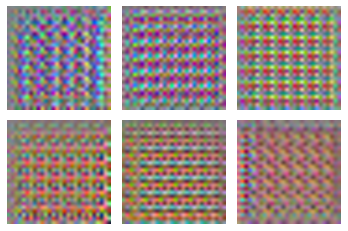

In [34]:
images = visual_filters(celeba_dataset, z_dim, celeba_dataset.image_mode, 
                        function='optimize_images', conv_id=1, num_iterations=50)
filters.plot_images(images)

Due to the two convolutional layers, it is more difficult to find some visible patterns we can detect with our eyes. However, to detect more complex lines and patterns, we need to add convolutional layers more and more and use other machine learning and deep learning technics.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.